In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import re
from gensim.test.utils import datapath
from gensim.models.fasttext import *
import gensim.downloader as api
import os
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /home/gleb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
cap_path = datapath(os.getcwd() + "/data/cc.en.300.bin.gz")
fbkv = load_facebook_vectors(cap_path)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModelWithLMHead.from_pretrained("roberta-large")

In [5]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':100})

In [6]:
def lget(lst, pos):
    return list(map(lambda x: x[pos], lst))

def dget(lst, pos):    
    return list(map(lambda x: '{0:.2f}'.format(x[pos]), lst))

def mk_graph(x1, x2):
    x1 = list(filter(lambda x: x > -2 and x < 0.99, x1))[:40]
    kwargs = dict(alpha=0.3, bins=20)

    plt.hist(x1, **kwargs, color='g', label='FastText score')
    plt.gca().set(title='Top 40 masks histogram of embeddings score', ylabel='Count')

    plt.legend()
    plt.show()
    
def mk_graph2(x1):
    kwargs = dict(alpha=1, bins=50)

    plt.hist(x1, **kwargs, color='r', label='Weighted score')
    plt.gca().set(
        title='Distribution of weighted score of top 200 unfiltered results (Target excluded)', 
        ylabel='Count'
    )

    plt.legend()
    plt.show()
    
def calc_w(x, y, w):
    return x * w[0] + y * w[1]

# https://www.nltk.org/howto/wordnet.html
def print_wordnet_data(target, wnl):
    syns = wordnet.synsets(target)
    lemmas = set()
    hyponyms = set()
    for s in syns:
        if (s.lexname()[0] == wnl):
            for l in s.lemmas():
                lemmas.add(l.name())
            for h in s.hyponyms():
                for l in h.lemmas():
                    hyponyms.add(l.name())
    
    print("Lemmas:", lemmas)
    print("Hyponyms:", hyponyms)
                
def find_top(sentence, k, top_bert, bert_norm, min_ftext, weights): 
    print("Input: ", sentence)
    smatch = re.search("(\w+)\?(\w+)?", sentence)
    target = None
    wnl = None
    
    if (smatch):
        target = re.sub("\?", "", smatch.group(1))
        wnl = smatch.group(2)
        target = target.strip()
        
    sequence = re.sub("(\w+)?\?(\w+)?", tokenizer.mask_token, sentence)

    input = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

    token_logits = model(input)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]

    # Filter top <top_bert> results of bert output
    topk = torch.topk(mask_token_logits, top_bert, dim=1)
    top_tokens = list(zip(topk.indices[0].tolist(), topk.values[0].tolist()))

    unfiltered = list()
    filtered = list()
    
    norm_d = top_tokens[bert_norm - 1][1]
    norm_k = top_tokens[0][1] - norm_d
    
    # Filter bert output by <min_ftext>
    for token, value in top_tokens:
        word = tokenizer.decode([token]).strip()
        nvalue = (value - norm_d) / norm_k
        sim = None

        sim = fbkv.similarity(target, word)

        if (sim >= min_ftext):
            filtered.append((word, value, nvalue, sim, calc_w(nvalue, sim, weights)))
                
        unfiltered.append((word, value, nvalue, sim, calc_w(nvalue, sim, weights)))
        
    kfiltered = filtered[:k]
    kunfiltered = unfiltered[:k]
    
    kfiltered = sorted(kfiltered, key = lambda x: -x[len(x) - 1])
    kunfiltered = sorted(kunfiltered, key = lambda x: -x[len(x) - 1])
  
    if (min_ftext > 0):
        print("Unfiltered top:")

        print(pd.DataFrame({
            'word': lget(kunfiltered, 0),
            'bert': dget(kunfiltered, 1),
            'normalized': dget(kunfiltered, 2),
            'ftext': dget(kunfiltered, 3),
            'score': dget(kunfiltered, 4)
        }))
    
    print("Filtered top:")
        
    print(pd.DataFrame({
        'word': lget(kfiltered, 0),
        'bert': dget(kfiltered, 1),
        'normalized': dget(kfiltered, 2),
        'ftext': dget(kfiltered, 3),
        'score': dget(kfiltered, 4)
    }))
    
    mk_graph(lget(unfiltered, 2)[:100], lget(unfiltered, 3)[:100])
    mk_graph2(lget(list(filter(lambda x: x[0] != target, unfiltered)), 4))
        
    if (target != None):
        vec = tokenizer.encode(target, return_tensors="pt")[0]
        if (len(vec) == 3):
            tk = vec[1].item()
            pos = None
            score = None
            
            for e, (t, v) in enumerate(top_tokens):
                if (t == tk):
                    pos = e
                    score = v
                    break
            print("Original word position: ", e, "; score: ", score)
        else: 
            if (len(vec) > 3):
                print("Original word is more then 1 token")
                print(tokenizer.tokenize(target))
            else:
                print("Original word wasn't found")
                
        if (wnl != None):
            print_wordnet_data(target, wnl)
    
    print("===================")
    
def do_find(s):
    find_top(s, 20, 200, 200, 0.25, [1, 1]) 
    
base_samples = [
    "what's the local weather?n forecast",
    "chance of rain?n tomorrow in Moscow",
    "chance of rain?n tomorrow in city",
    "set the lights?n on in the entire house",
    "set the lights on in the entire house?n",
    "turn the lights off in the guest?a bedroom",
    "turn the lights off in the guest bedroom?n"
]

## Random wiki how to articles
articles = [
    "how to use a sharpening steel?n",
    "how to identify?v and treat liver shunts in cats",
    "how to identify and treat?v liver shunts in cats",
    "use enamel paint?n on a stove",
    "escape a sinking?a ship",
    "escape a sinking ship?n",
    "reduce the effect?n of macular degeneration",
    "recognize sign?n of an abusive person",
    "recognize signs of an abusive person?n",
    "make wine?n vinegar",
    "prepare boneless skinless chicken?n thighs",
    "what can you eat with type 2 diabetes?n"
]

Input:  what's the local weather?n forecast
Unfiltered top:
             word   bert normalized ftext score
0         weather  58.94       1.00  1.00  2.00
1            rain  54.68       0.50  0.58  1.09
2     temperature  55.83       0.64  0.45  1.09
3            snow  55.37       0.59  0.49  1.08
4        rainfall  54.86       0.53  0.50  1.02
5          winter  53.39       0.35  0.55  0.91
6           storm  53.71       0.39  0.50  0.89
7   precipitation  54.29       0.46  0.41  0.87
8         traffic  54.94       0.53  0.32  0.86
9         weekend  54.44       0.48  0.35  0.82
10           heat  53.66       0.39  0.37  0.75
11        tornado  53.73       0.39  0.34  0.73
12          radar  53.73       0.39  0.32  0.71
13        heating  53.61       0.38  0.29  0.68
14        driving  54.14       0.44  0.22  0.67
15         travel  53.82       0.40  0.26  0.66
16           fire  53.77       0.40  0.25  0.65
17        morning  53.34       0.35  0.30  0.65
18         school  54.50    

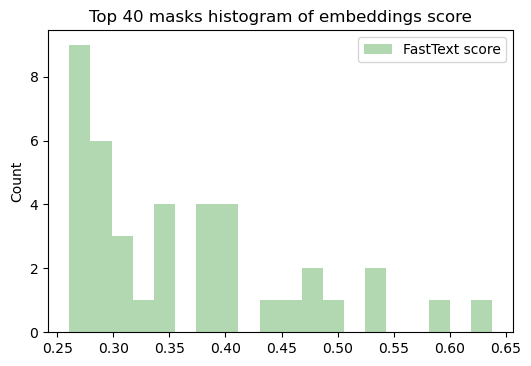

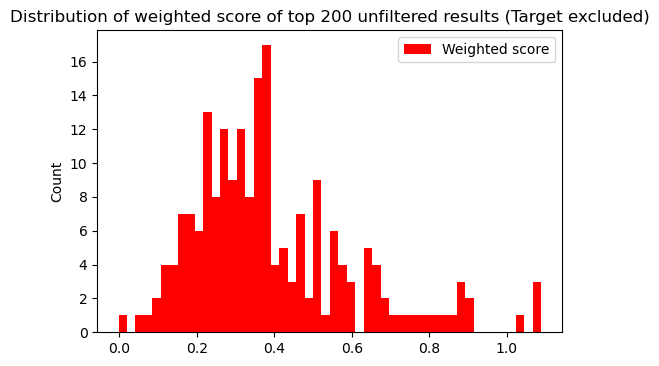

Original word position:  0 ; score:  58.944068908691406
Lemmas: {'conditions', 'weather', 'atmospheric_condition', 'weather_condition'}
Hyponyms: {'warming', 'wave', 'downfall', 'current_of_air', 'atmosphere', 'elements', 'air_current', 'inclemency', 'wind', 'thaw', 'hot_weather', 'good_weather', 'fair_weather', 'temperateness', 'precipitation', 'atmospheric_state', 'bad_weather', 'cold_weather', 'sunshine', 'thawing', 'inclementness'}
Input:  chance of rain?n tomorrow in Moscow
Unfiltered top:
          word   bert normalized ftext score
0     protests  56.42       1.00  0.13  1.13
1      protest  55.55       0.82  0.14  0.97
2        Putin  55.87       0.89  0.01  0.90
3    fireworks  54.10       0.53  0.28  0.80
4        march  54.19       0.54  0.23  0.78
5        peace  54.64       0.64  0.12  0.76
6     Olympics  54.79       0.67  0.08  0.75
7       events  54.42       0.59  0.12  0.71
8     violence  53.88       0.48  0.19  0.67
9    emergency  53.95       0.50  0.15  0.65
10   

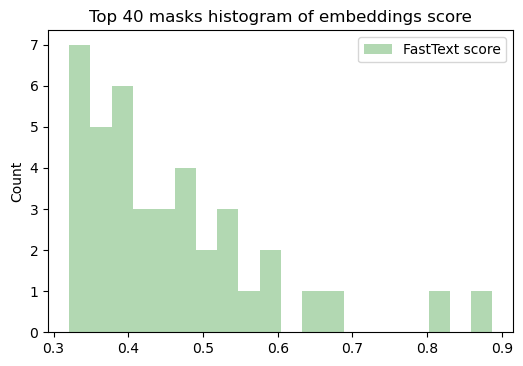

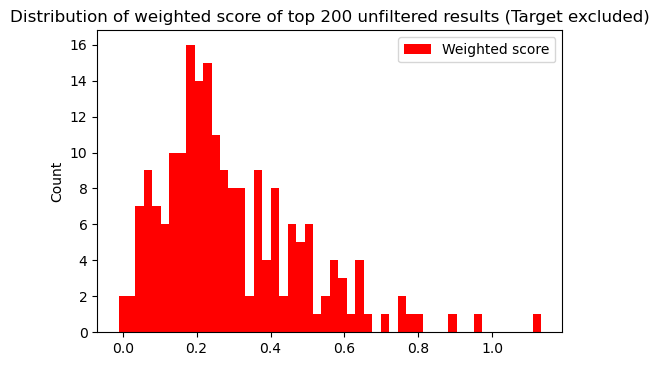

Original word position:  199 ; score:  None
Lemmas: {'rainfall', 'rainwater', 'pelting', 'rain'}
Hyponyms: {'rainstorm', 'deluge', 'mizzle', 'rain_shower', 'torrent', 'downpour', 'cloudburst', 'monsoon', 'waterspout', 'soaker', 'shower', 'drizzle', 'pelter'}
Input:  chance of rain?n tomorrow in city
Unfiltered top:
         word   bert normalized ftext score
0        rain  56.93       0.87  1.00  1.87
1        snow  56.99       0.89  0.59  1.48
2   fireworks  57.38       1.00  0.28  1.28
3      storms  55.70       0.53  0.55  1.07
4    flooding  55.76       0.54  0.48  1.02
5    protests  56.79       0.83  0.13  0.97
6    violence  56.53       0.76  0.19  0.95
7     eclipse  56.04       0.62  0.21  0.83
8    homeless  56.10       0.64  0.16  0.80
9    concerts  56.00       0.61  0.13  0.74
10   meetings  56.24       0.68  0.06  0.74
11     police  55.85       0.57  0.15  0.72
12  thousands  55.87       0.58  0.13  0.71
13    schools  56.07       0.63  0.08  0.71
14       work  55.97   

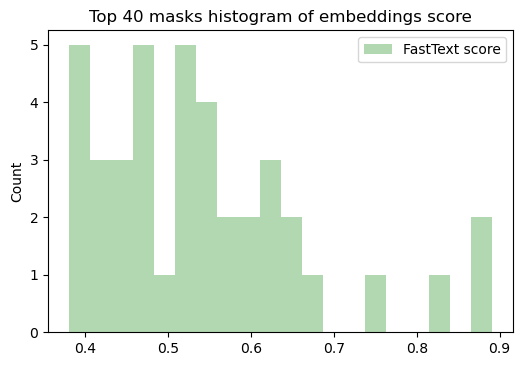

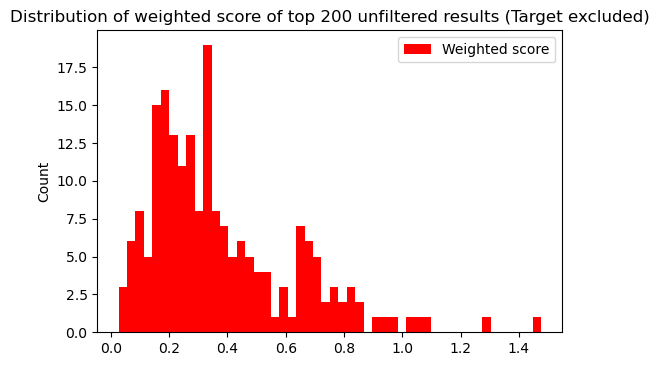

Original word position:  2 ; score:  56.93498992919922
Lemmas: {'rainfall', 'rainwater', 'pelting', 'rain'}
Hyponyms: {'rainstorm', 'deluge', 'mizzle', 'rain_shower', 'torrent', 'downpour', 'cloudburst', 'monsoon', 'waterspout', 'soaker', 'shower', 'drizzle', 'pelter'}
Input:  set the lights?n on in the entire house
Unfiltered top:
           word   bert normalized ftext score
0        lights  61.43       1.00  1.00  2.00
1         light  58.84       0.73  0.63  1.37
2         lamps  56.34       0.48  0.68  1.16
3      lighting  56.02       0.45  0.71  1.15
4          heat  60.00       0.85  0.25  1.10
5   electricity  58.08       0.66  0.36  1.02
6         water  58.60       0.71  0.22  0.93
7          fans  58.79       0.73  0.20  0.93
8       heating  58.15       0.66  0.26  0.92
9            AC  58.90       0.74  0.17  0.91
10        power  57.69       0.62  0.29  0.91
11       heater  56.83       0.53  0.32  0.85
12          fan  58.24       0.67  0.15  0.83
13        stove  56.83

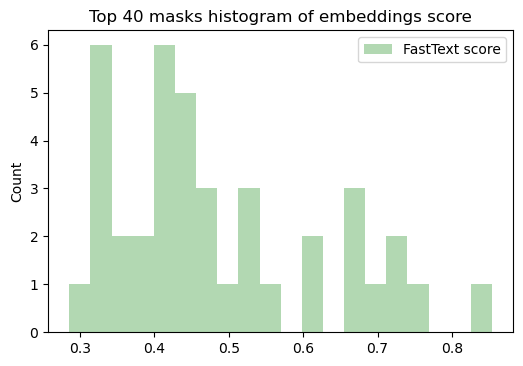

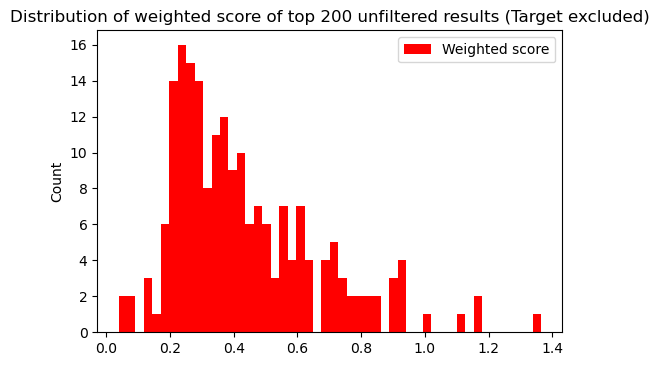

Original word position:  0 ; score:  61.43402862548828
Lemmas: {'Inner_Light', 'Light_Within', 'igniter', 'illumination', 'visible_light', 'Christ_Within', 'luminousness', 'spark', 'Light', 'lightness', 'sparkle', 'visible_radiation', 'brightness', 'brightness_level', 'lighting', 'lighter', 'twinkle', 'light_source', 'light', 'luminance', 'ignitor', 'luminosity'}
Hyponyms: {'panel_light', 'lamplight', 'firelight', 'counterglow', 'illuminance', 'glowing', 'anchor_light', 'sidelight', 'daylight', 'brightness', 'flasher', "will-o'-the-wisp", 'primer', 'houselights', 'torchlight', 'sun', 'gloriole', 'incandescence', 'scintillation', 'room_light', 'shaft', 'glory', 'match', 'fusee', 'gegenschein', 'ray_of_light', 'headlight', 'running_light', 'blinker', 'half-light', 'torch', 'fluorescence', 'night-light', 'strip_lighting', 'light_beam', 'riding_lamp', 'highlighting', 'sunlight', 'sunniness', 'priming', 'shooting_star', 'moonlight', 'traffic_signal', 'pocket_lighter', 'glow', 'radiance', 'f

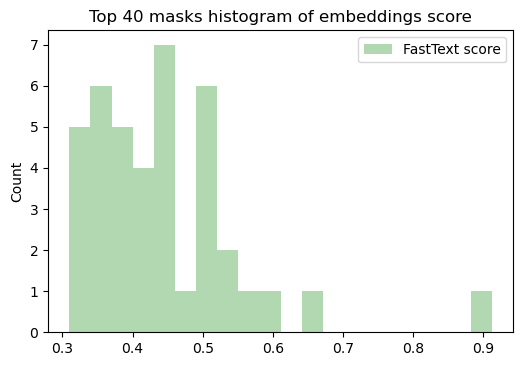

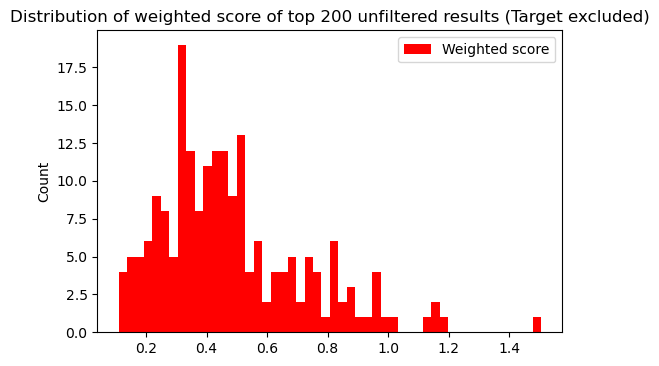

Original word position:  1 ; score:  63.09485626220703
Lemmas: {'star_sign', 'menage', 'house', 'sign_of_the_zodiac', 'planetary_house', 'home', 'mansion', 'business_firm', 'sign', 'household', 'theater', 'theatre', 'firm', 'family'}
Hyponyms: {'pumping_station', 'duplex_house', 'Seanad', 'pump_house', 'oast_house', 'meat_house', 'maisonette', 'row_house', 'courthouse', 'theater_in_the_round', 'vaudeville_theatre', 'opera_house', 'tract_house', 'rooming_house', 'solar_house', 'publishing_firm', "doll's_house", 'consulting_company', 'little_theater', 'villa', 'gatehouse', 'lodge', 'frat_house', 'House_of_Lords', 'royal_house', 'Dail', 'bagnio', 'conjugal_family', 'safe_house', 'accounting_firm', 'US_House_of_Representatives', 'cottage', 'boarding_house', 'movie_theater', 'manse', 'movie_theatre', 'boardinghouse', 'menage_a_trois', 'auction_house', 'home_theatre', 'House_of_Commons', 'picture_palace', 'fraternity_house', 'single_dwelling', 'farmhouse', 'royal_line', 'royalty', 'vaudevill

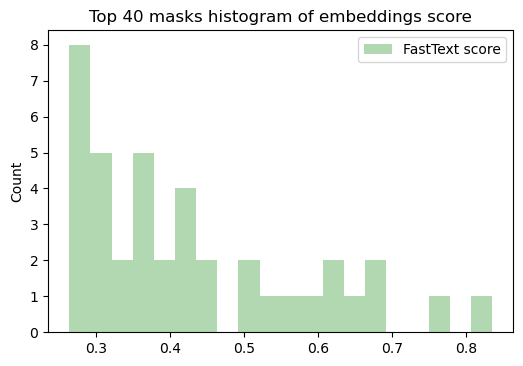

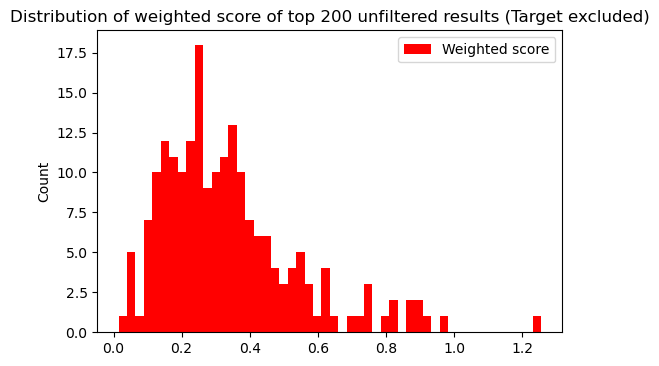

Original word position:  1 ; score:  60.62987518310547
Lemmas: set()
Hyponyms: set()
Input:  turn the lights off in the guest bedroom?n
Unfiltered top:
         word   bert normalized ftext score
0     bedroom  61.55       0.87  1.00  1.87
1        room  62.96       1.00  0.60  1.60
2    bathroom  60.76       0.80  0.70  1.50
3    bedrooms  59.71       0.70  0.76  1.47
4       rooms  61.59       0.88  0.50  1.37
5        room  60.06       0.74  0.60  1.34
6        bath  58.99       0.64  0.59  1.23
7       rooms  59.17       0.66  0.50  1.16
8         bed  57.82       0.53  0.60  1.14
9       house  58.14       0.56  0.57  1.13
10      house  58.11       0.56  0.57  1.13
11  bathrooms  57.79       0.53  0.55  1.08
12      suite  57.81       0.53  0.49  1.02
13      cabin  58.14       0.56  0.38  0.94
14     lounge  56.86       0.45  0.46  0.90
15     suites  57.06       0.46  0.42  0.89
16   quarters  58.04       0.55  0.33  0.89
17       area  58.70       0.61  0.25  0.87
18   restroo

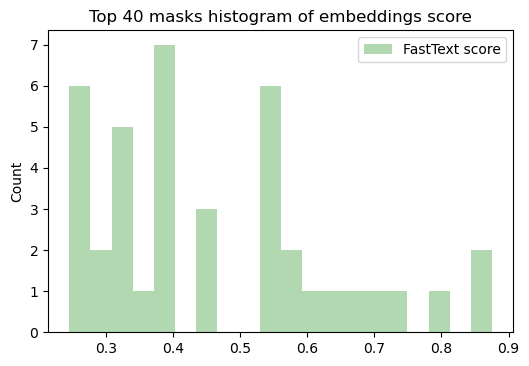

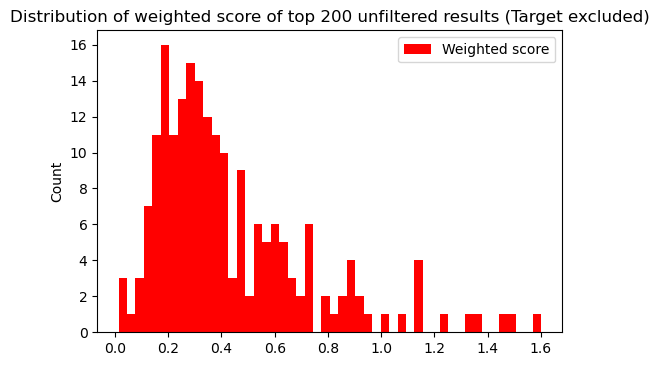

Original word position:  2 ; score:  61.55071258544922
Lemmas: {'chamber', 'sleeping_accommodation', 'bedchamber', 'sleeping_room', 'bedroom'}
Hyponyms: {'dormitory_room', 'dorm_room', 'guestroom', 'boudoir', 'dormitory', "child's_room", 'hotel_room', 'motel_room', 'master_bedroom'}


In [7]:
for s in base_samples:
    do_find(s)

Input:  how to use a sharpening steel?n
Unfiltered top:
          word   bert normalized ftext score
0        steel  52.06       0.50  1.00  1.50
1         iron  54.96       0.90  0.59  1.50
2        stone  54.87       0.89  0.42  1.31
3        knife  55.37       0.96  0.33  1.29
4       pencil  55.19       0.94  0.26  1.20
5         tool  55.64       1.00  0.19  1.19
6        wheel  54.34       0.82  0.28  1.10
7        blade  52.89       0.61  0.39  1.01
8          pen  53.86       0.75  0.22  0.97
9        brush  53.13       0.65  0.21  0.85
10      device  53.61       0.71  0.10  0.82
11       stick  52.60       0.57  0.21  0.78
12         tip  52.83       0.60  0.18  0.78
13         bar  52.10       0.50  0.28  0.78
14       spoon  52.13       0.51  0.27  0.78
15         pin  52.42       0.55  0.22  0.76
16     surface  52.01       0.49  0.24  0.73
17  instrument  51.97       0.48  0.21  0.70
18       board  52.18       0.51  0.14  0.65
19       press  52.03       0.49  0.09  0.58

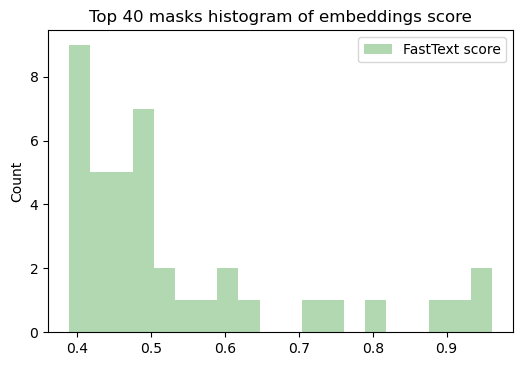

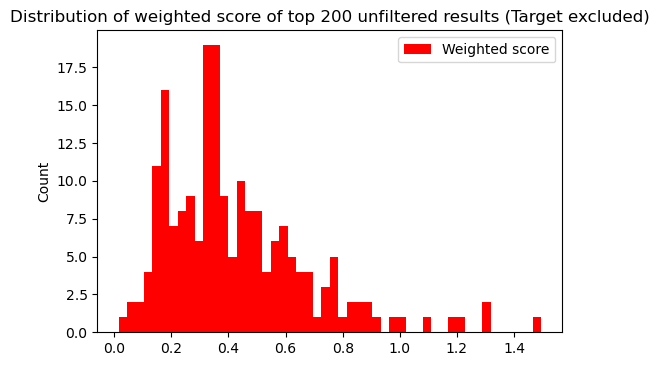

Original word position:  16 ; score:  52.06224060058594
Lemmas: {'brand', 'steel', 'blade', 'sword'}
Hyponyms: {'cavalry_sword', 'fencing_sword', 'crucible_steel', 'broadsword', 'saber', 'alloy_steel', 'backsword', 'austenitic_steel', 'falchion', 'structural_steel', 'low-carbon_steel', 'carbon_steel', 'mild_steel', 'Damask_steel', 'rapier', 'hard_steel', 'soft-cast_steel', 'cutlas', 'tuck', 'medium_steel', 'case-hardened_steel', 'chisel_steel', 'quenched_steel', 'Damascus_steel', 'sabre', 'cutlass'}
Input:  how to identify?v and treat liver shunts in cats
Unfiltered top:
         word   bert normalized ftext score
0    identify  59.71       0.79  1.00  1.79
1    diagnose  61.97       1.00  0.51  1.51
2      detect  59.45       0.76  0.62  1.39
3   recognize  58.66       0.69  0.61  1.30
4        find  59.16       0.74  0.53  1.26
5     prevent  60.22       0.84  0.41  1.25
6      locate  56.84       0.52  0.63  1.15
7        spot  60.44       0.86  0.28  1.14
8      assess  56.01      

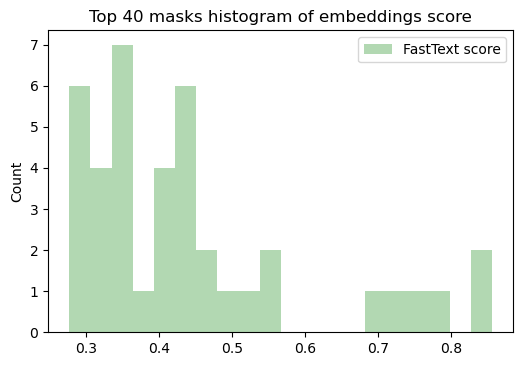

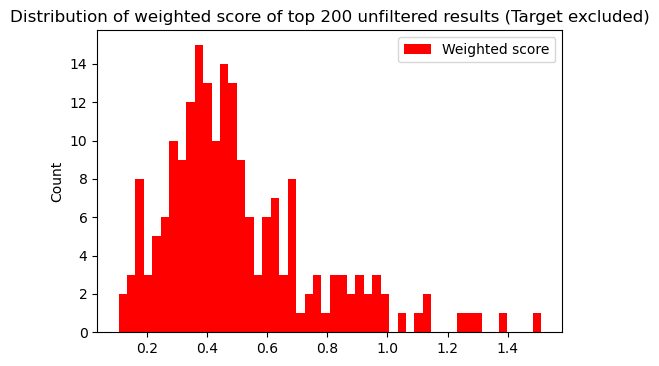

Original word position:  3 ; score:  59.7053337097168
Lemmas: {'key', 'distinguish', 'place', 'describe', 'key_out', 'name', 'identify', 'discover'}
Hyponyms: {'misidentify', 'severalise', 'enumerate', 'mistake', 'recite', 'distinguish', 'secern', 'secernate', 'itemize', 'itemise', 'typecast', 'tell_apart', 'announce', 'separate', 'number', 'type', 'list', 'severalize', 'differentiate', 'tell', 'taste'}
Input:  how to identify and treat?v liver shunts in cats
Unfiltered top:
        word   bert normalized ftext score
0      treat  62.70       1.00  1.00  2.00
1   diagnose  58.35       0.55  0.49  1.04
2    prevent  59.01       0.62  0.41  1.03
3     manage  59.27       0.65  0.34  0.99
4       cure  57.31       0.45  0.41  0.86
5     remove  58.88       0.61  0.23  0.84
6       stop  57.51       0.47  0.31  0.78
7     repair  58.93       0.61  0.14  0.76
8       heal  56.64       0.38  0.36  0.74
9     detect  56.89       0.40  0.32  0.72
10       fix  57.18       0.43  0.29  0.72
11  

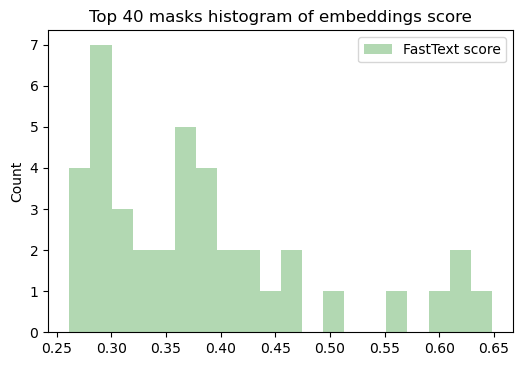

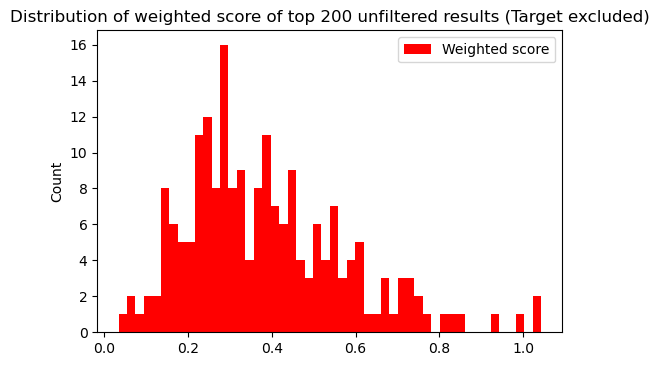

Original word position:  0 ; score:  62.69602584838867
Lemmas: {'deal', 'address', 'plow', 'regale', 'do_by', 'cover', 'treat', 'handle', 'process', 'care_for'}
Hyponyms: {'smooth_over', 'maltreat', 'dispense', 'bleed', 'chrome', 'sulphur', 'malt', 'oxygenise', 'skate_over', 'cocker', 'leech', 'detoxify', 'carbonate', 'mollycoddle', 'psychoanalyze', 'propagate', 'mercerise', 'shock', 'ammoniate', 'wine', 'step', 'oxygenate', 'detox', 'fumigate', 'brutalize', 'bituminise', 'fume', 'aerate', 'bemock', 'oxygenize', 'refine', 'phlebotomise', 'dose', 'featherbed', 'nurse', 'seed', 'discuss', 'snub', 'bromate', 'vet', 'irrigate', 'theologize', 'baby', 'run', 'upstage', 'cut', 'phlebotomize', 'discourse', 'massage', 'manipulate', 'Agenise', 'fluoridise', 'camphorate', 'abuse', 'handle_with_kid_gloves', 'relieve', 'strong-arm', 'mercerize', 'reverberate', 'brominate', 'bituminize', 'mistreat', 'cauterise', 'nitrify', 'theologise', 'cosset', 'transfuse', 'skimp_over', 'cauterize', 'sulfur', 'ir

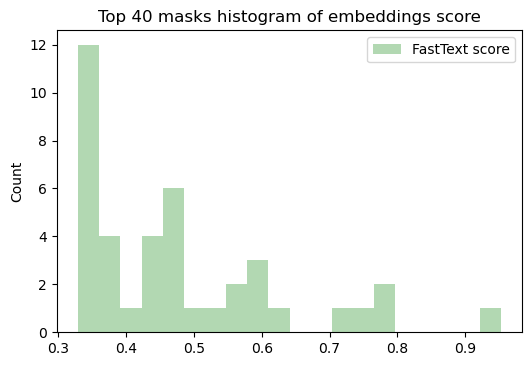

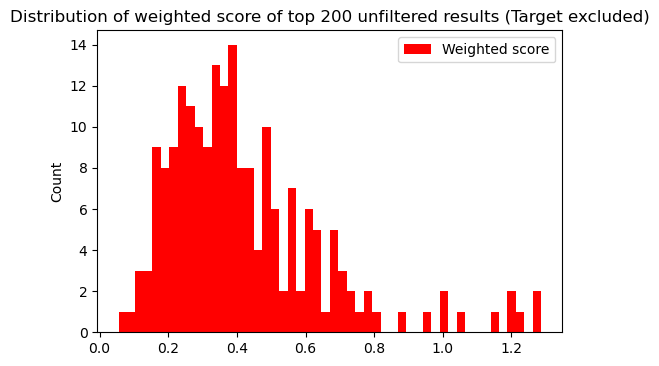

Original word position:  9 ; score:  54.7498779296875
Lemmas: {'paint', 'key', 'pigment', 'blusher', 'rouge'}
Hyponyms: {'encaustic', 'finger_paint', 'oil_paint', 'distemper', 'antifouling_paint', 'acrylic', 'house_paint', 'semigloss', 'coat_of_paint', 'spray_paint', 'water-base_paint', 'fingerpaint', 'acrylic_paint', 'enamel', 'housepaint'}
Input:  escape a sinking?a ship
Unfiltered top:
         word   bert normalized ftext score
0     sinking  56.10       0.64  1.00  1.64
1      cruise  58.43       1.00  0.33  1.33
2       cargo  56.79       0.75  0.27  1.02
3      pirate  56.48       0.70  0.20  0.90
4     sailing  54.57       0.41  0.38  0.79
5   container  55.71       0.58  0.17  0.75
6   passenger  55.33       0.53  0.19  0.71
7       ghost  55.46       0.54  0.15  0.70
8        tall  55.66       0.57  0.12  0.69
9       small  55.66       0.57  0.09  0.67
10     rocket  54.86       0.45  0.18  0.63
11        new  55.23       0.51  0.12  0.63
12       Navy  54.35       0.37  0.2

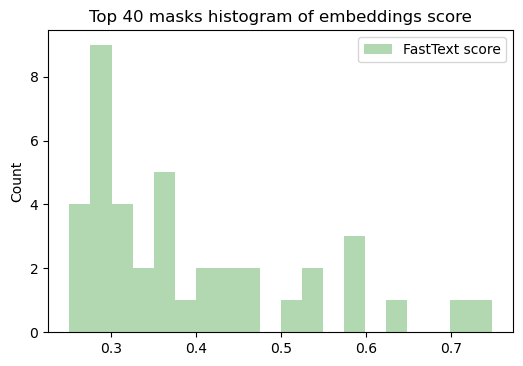

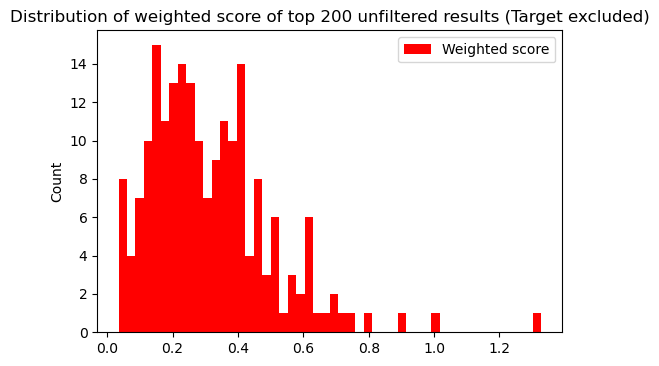

Original word position:  3 ; score:  56.103729248046875
Lemmas: set()
Hyponyms: set()
Input:  escape a sinking ship?n
Unfiltered top:
        word   bert normalized ftext score
0       ship  61.24       1.00  1.00  2.00
1       boat  58.32       0.66  0.55  1.21
2     vessel  57.68       0.59  0.61  1.19
3       Ship  56.07       0.40  0.61  1.01
4    Titanic  55.90       0.38  0.46  0.84
5       dock  55.24       0.30  0.48  0.78
6     planet  56.00       0.39  0.34  0.73
7      world  56.74       0.48  0.24  0.71
8      train  55.96       0.38  0.29  0.68
9    economy  56.64       0.46  0.21  0.67
10     liner  55.23       0.30  0.32  0.62
11      city  56.41       0.44  0.18  0.62
12  building  55.57       0.34  0.24  0.58
13      star  55.81       0.37  0.19  0.55
14     house  55.49       0.33  0.22  0.55
15      town  55.57       0.34  0.19  0.53
16     state  55.45       0.33  0.12  0.44
17       man  55.27       0.30  0.14  0.44
18         ?  55.81       0.37  0.05  0.42
19   f

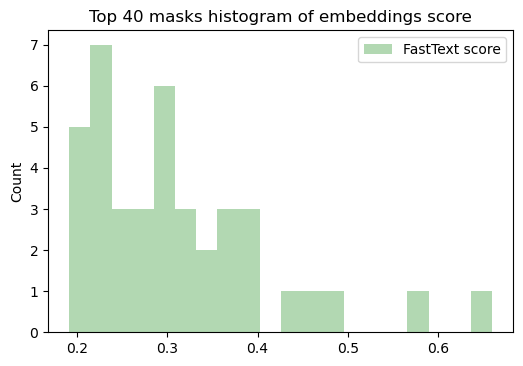

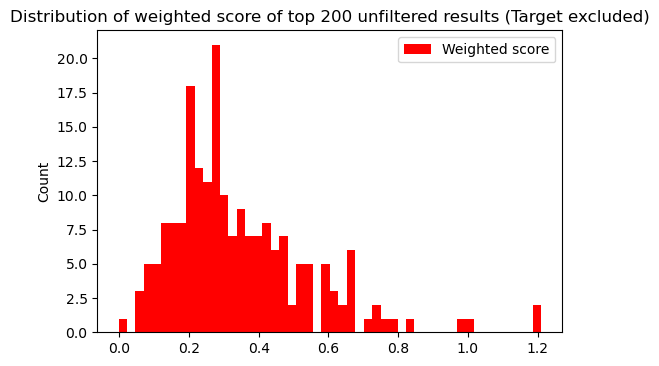

Original word position:  0 ; score:  61.24334716796875
Lemmas: {'ship'}
Hyponyms: {'blockade-runner', 'slave_ship', 'gas-turbine_ship', 'hospital_ship', 'hulk', 'pirate_ship', 'sister_ship', 'whaling_ship', 'school_ship', 'derelict', 'tender', 'whaler', 'treasure_ship', 'wreck', 'steamer', 'training_ship', 'abandoned_ship', 'combat_ship', 'troopship', 'shipwreck', 'cargo_ship', 'transport_ship', 'icebreaker', 'war_vessel', 'pirate', 'nuclear-powered_ship', 'warship', 'iceboat', 'cargo_vessel', 'small_ship', 'passenger_ship', 'minesweeper', 'supply_ship', 'flagship', 'minelayer', 'steamship', 'lightship', 'three-decker'}
Input:  reduce the effect?n of macular degeneration
Unfiltered top:
           word   bert normalized ftext score
0       effects  56.85       0.85  0.75  1.60
1        causes  57.66       1.00  0.36  1.36
2        impact  55.53       0.60  0.64  1.24
3         cause  56.33       0.75  0.42  1.17
4      symptoms  57.25       0.92  0.22  1.14
5         onset  56.84      

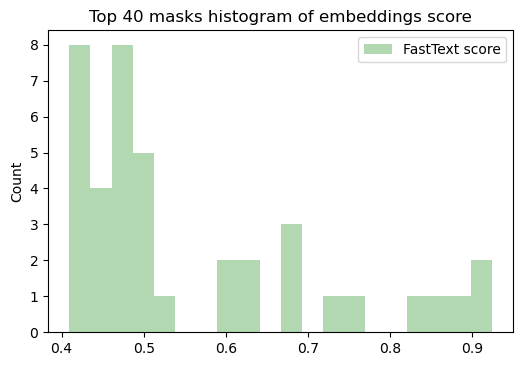

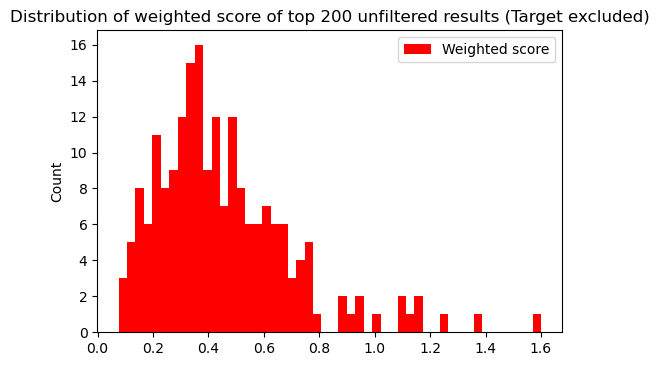

Original word position:  40 ; score:  54.533267974853516
Lemmas: {'impression', 'event', 'consequence', 'outcome', 'upshot', 'issue', 'force', 'burden', 'effect', 'core', 'result', 'gist', 'essence'}
Hyponyms: {'image', 'byproduct', 'branch', 'brisance', 'change', 'dent', 'bummer', 'offshoot', 'Coriolis_effect', 'materialization', 'influence', 'aftermath', 'mark', 'placebo_effect', 'harvest', 'knock-on_effect', 'offset', 'repercussion', 'special_effect', 'bandwagon_effect', 'by-product', 'offspring', 'tout_ensemble', 'impact', 'sound_effect', 'coattails_effect', 'aftereffect', 'butterfly_effect', 'fallout', 'backwash', 'outgrowth', 'figure', 'response', 'position_effect', 'product', 'side_effect', 'domino_effect', 'wallop', 'wake', 'materialisation', 'reverberation', 'spillover'}
Input:  recognize sign?n of an abusive person
Unfiltered top:
               word   bert normalized  ftext score
0              sign  48.84       0.53   1.00  1.53
1             signs  49.38       0.66   0.72 

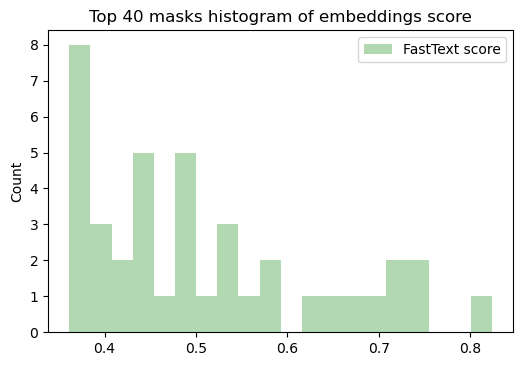

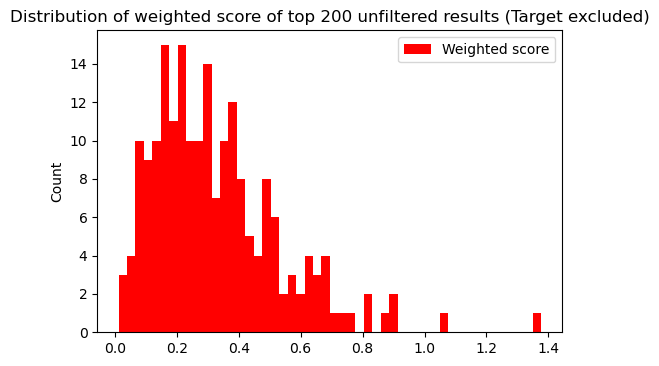

Original word position:  15 ; score:  48.83759307861328
Lemmas: {'signaling', 'star_sign', 'house', 'sign_of_the_zodiac', 'polarity', 'planetary_house', 'mansion', 'signboard', 'sign', 'augury', 'mark', 'preindication', 'signal', 'foretoken'}
Hyponyms: {'poster', 'curfew', 'portent', 'phone_number', 'prognostic', 'storm_signal', 'positiveness', 'guidepost', 'indicator', 'billboard', 'starting_signal', 'bugle_call', 'minus_sign', 'war_cloud', 'alarum', 'whistling', 'time_signal', 'placard', 'signpost', 'input', 'input_signal', 'street_sign', 'presage', 'radical_sign', 'retreat', 'animal_communication', 'radiotelegraphic_signal', 'visual_signal', 'shingle', 'negativity', 'radio_beam', 'omen', 'all_clear', 'positivity', 'output_signal', 'ticktack', 'negativeness', 'whistle', 'distress_call', 'number', 'dog-ear', 'scoreboard', 'card', 'prognostication', 'alert', 'start', 'telephone_number', 'vital_sign', 'distress_signal', 'telegraphic_signal', 'beam', 'symbol', 'high_sign', 'drumbeat', 's

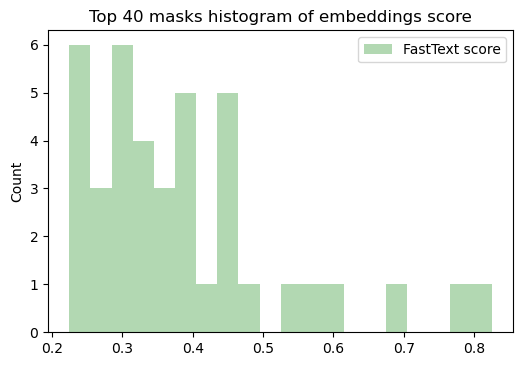

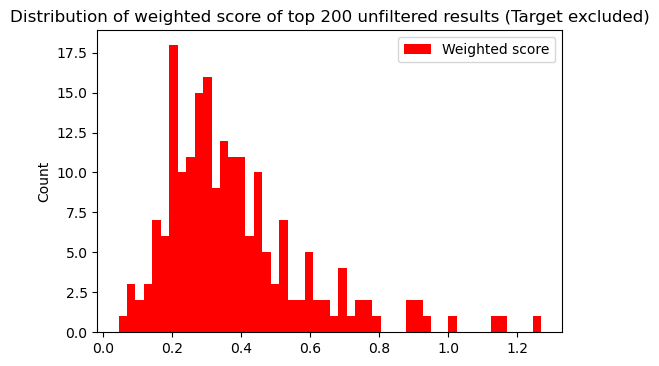

Original word position:  15 ; score:  56.78102111816406
Lemmas: {'individual', 'soul', 'person', 'mortal', 'someone', 'somebody'}
Hyponyms: {'blackamoor', 'assimilator', 'image', 'outdoorsman', 'slave', 'malcontent', 'visionary', 'wanter', 'commoner', 'noncompliant', 'good_person', 'rusher', 'debaser', 'vanisher', 'applied_scientist', 'unraveller', 'endomorph', 'observer', 'equal', 'romper', 'ape', 'squinter', 'first_person', 'mesomorph', 'nude', 'chutzpanik', 'rich_person', 'homosexual', 'worker', 'look-alike', 'unwelcome_person', 'visually_impaired_person', 'deliverer', 'objector', 'smotherer', 'shaker', 'adventurer', 'fiduciary', 'snuffler', 'compeer', 'terror', 'dyslectic', 'female', 'occultist', 'Elizabethan', 'mangler', 'literate_person', 'scientist', 'advisee', 'monolingual', 'red-header', 'collector', 'sensualist', 'cripple', 'swayer', 'technologist', 'freewheeler', 'personage', 'baby', 'Jew', 'faller', 'blond', 'handicapped_person', 'ward', 'Native_American', 'watcher', 'emoti

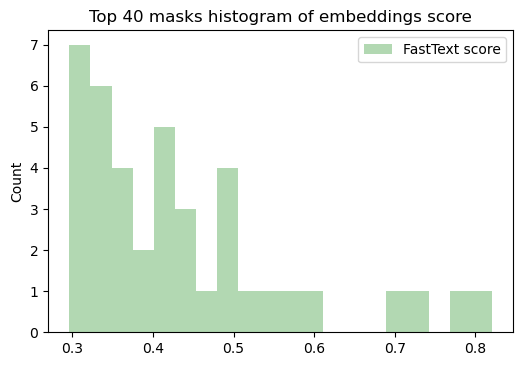

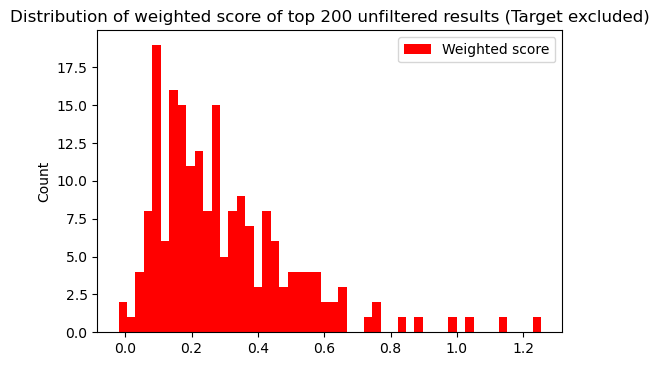

Original word position:  7 ; score:  46.52012252807617
Lemmas: {'wine-coloured', 'wine', 'wine-colored', 'vino'}
Hyponyms: {'sacramental_wine', 'Bordeaux_wine', 'varietal_wine', 'pink_wine', 'California_wine', 'Bordeaux', 'sparkling_wine', 'red_wine', 'dessert_wine', 'Tokay', 'Burgundy', 'macon', 'varietal', 'maconnais', 'altar_wine', 'vintage', 'Burgundy_wine', 'rose', 'fortified_wine', 'vermouth', 'Rhone_wine', 'table_wine', 'Dubonnet', 'blush_wine', 'rose_wine', 'Cotes_de_Provence', 'white_wine', 'generic_wine', 'retsina', 'generic', 'plonk', 'jug_wine', 'mulled_wine'}
Input:  prepare boneless skinless chicken?n thighs
Unfiltered top:
          word   bert normalized ftext score
0      chicken  56.71       0.71  1.00  1.71
1        inner  58.67       1.00  0.18  1.18
2         calf  56.75       0.71  0.36  1.07
3        human  57.50       0.83  0.23  1.05
4        upper  58.20       0.93  0.11  1.04
5       female  57.02       0.75  0.23  0.99
6         male  56.92       0.74  0.23 

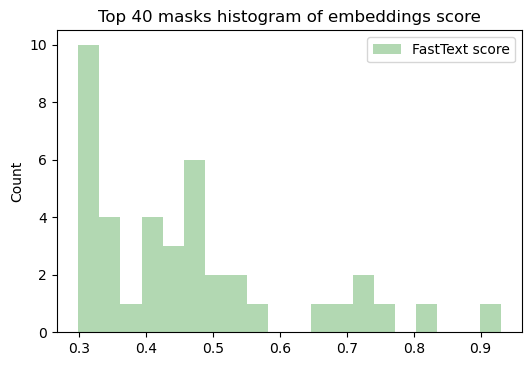

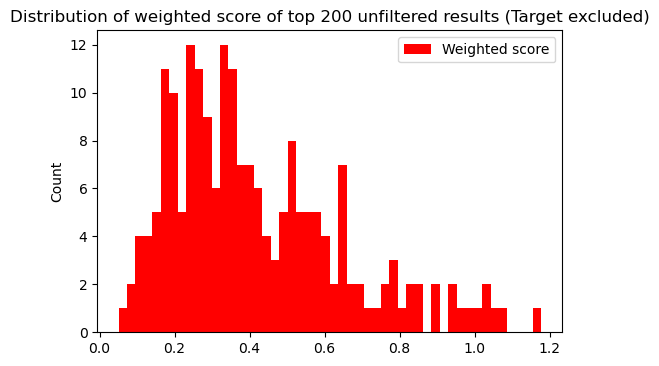

Original word position:  6 ; score:  56.70950698852539
Lemmas: {'poulet', 'chicken', 'wimp', 'Gallus_gallus', 'crybaby', 'volaille'}
Hyponyms: {'Dominique', 'Orpington', 'frier', 'roaster', 'cock', 'broiler', 'capon', 'spatchcock', 'rooster', 'fryer', 'biddy', 'hen', 'Dominick', 'spring_chicken', 'pullet', 'chick', 'Rhode_Island_red'}
Input:  what can you eat with type 2 diabetes?n
Unfiltered top:
            word   bert normalized ftext score
0       diabetes  60.86       1.00  1.00  2.00
1       Diabetes  56.97       0.69  0.78  1.47
2       diabetic  51.92       0.30  0.77  1.07
3        obesity  52.69       0.36  0.63  0.99
4   hypertension  51.71       0.28  0.68  0.97
5        insulin  52.34       0.33  0.62  0.95
6    cholesterol  52.23       0.32  0.53  0.85
7        disease  51.58       0.27  0.57  0.84
8          sugar  53.07       0.39  0.44  0.83
9         sugars  53.15       0.40  0.43  0.83
10             ?  57.78       0.76  0.06  0.82
11         blood  52.66       0.36 

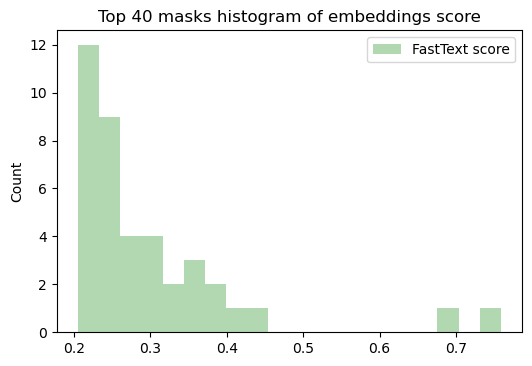

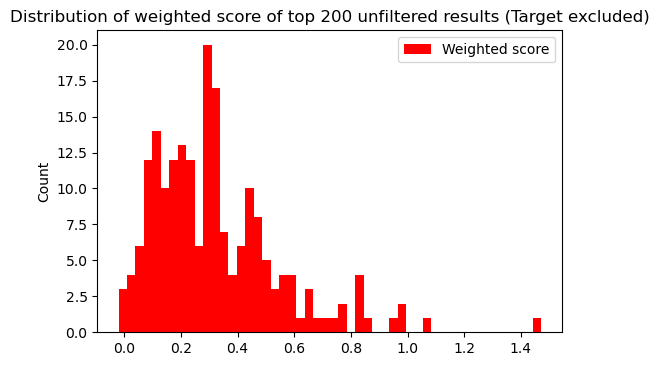

Original word position:  0 ; score:  60.86024475097656
Lemmas: {'diabetes'}
Hyponyms: {'diabetes_insipidus', 'diabetes_mellitus', 'DM'}


In [8]:
for a in articles:
    do_find(a)

Input:  what's the chance of rain? tomorrow?
Unfiltered top:
          word   bert normalized ftext score
0         rain  55.95       0.30  1.00  1.30
1      success  61.40       1.00  0.13  1.13
2         that  59.83       0.80  0.13  0.93
3      winning  59.19       0.72  0.09  0.81
4           it  58.50       0.63  0.18  0.81
5      victory  58.31       0.61  0.17  0.78
6         this  58.27       0.60  0.12  0.72
7    happening  57.54       0.51  0.16  0.67
8      failure  57.43       0.49  0.12  0.61
9       change  57.08       0.45  0.15  0.60
10    survival  57.05       0.45  0.15  0.59
11  succeeding  57.60       0.52  0.05  0.56
12    disaster  56.16       0.33  0.22  0.55
13    recovery  56.90       0.43  0.11  0.54
14       dying  56.68       0.40  0.14  0.53
15      Brexit  56.94       0.43  0.08  0.51
16   surviving  56.52       0.38  0.10  0.48
17         war  56.41       0.36  0.09  0.46
18    miracles  55.78       0.28  0.17  0.45
19        them  55.80       0.29  0.12 

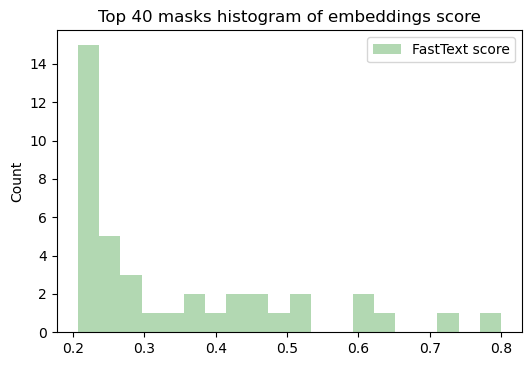

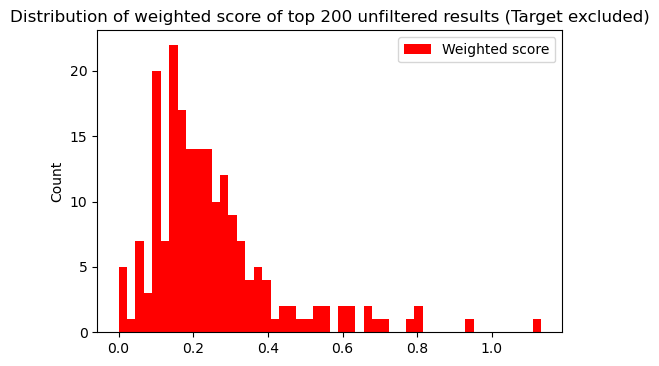

Original word position:  17 ; score:  55.94752883911133


In [16]:
# Example of usage
find_top(
    "what's the chance of rain? tomorrow?", # mark target word with ? 
    # For wordnet add lexname after question mark (i.e. "n" -- noun, "v" -- verb, "a" -- adjective)
    k = 20, # Filter best k results (by weighted score)
    top_bert = 200, # Number of initial filter of bert output 
    bert_norm = 200, # Use this position for normalization of bert output 
    min_ftext = 0.4, # Minimal required score of fast text  
    weights = [ # Weights of models scores to calculate total weighted score
        1, # bert
        1, # fast text
    ]
)
